In [4]:
# Load vgg16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input

inp_layer = Input(shape=(224, 224, 3))
vgg = VGG16(include_top=False, weights='imagenet', pooling='avg')

out_vgg = vgg(inp_layer)
print(vgg.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [5]:
# Preprocess
from keras.preprocessing.image import load_img, img_to_array

from IPython.display import Image, display
from os import listdir
from tqdm import tqdm

imagedir = 'data/images/'
textdir = 'data/text/Flickr8k.token.txt'

image_names = listdir(imagedir)


def load_images(dirname):
    images = {}
    for img_name in tqdm(image_names):
        img = load_img(dirname+img_name, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        
        name = img_name.split('.')[0]
        images[name] = img
        
    return images

image_dict = load_images(imagedir)
print('Total loadded:', len(image_dict))

100%|█████████████████████████████████████████████████████████████████████████████| 8091/8091 [01:16<00:00, 106.30it/s]


Total loadded: 8091


In [ ]:
# import string
'''def load_captions(filename):
    file = open(filename, 'r')
    
    text = file.read()
    
    captions = {}
    
    for line in tqdm(text.split('\n')):
        tokens = line.split()
        
        if len(line) < 2:
            continue # Wierd shit happened...
        
        img_id, img_desc = tokens[0], tokens[1:]
        img_id = img_id.split('.')[0]
        
        img_desc = ' '.join(img_desc)
        
        captions[img_id] = img_desc
        
    file.close()
    
    return captions

 
# clean description text
def clean_captions(captions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc in captions.items():
        # tokenize
        desc = desc.split()
        # convert to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation from each token
        desc = [w.translate(table) for w in desc]
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # store as string
        captions[key] =  ' '.join(desc)
 
# save descriptions to file, one per line
def save_doc(descriptions, filename):
    lines = list()
    for key, desc in descriptions.items():
        lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

captions_dict = load_captions(textdir)
clean_captions(captions_dict)

all_tokens = ' '.join(captions_dict.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))
# save descriptions
save_doc(captions_dict, 'descriptions.txt')
'''

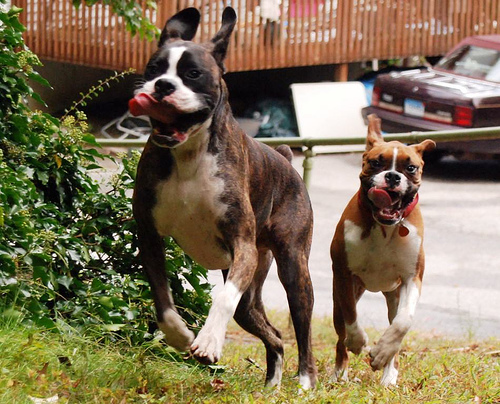

In [7]:
def data_generator(dirname, images, captions):
    for idx in listdir(dirname):
        yield [images[idx], captions[idx]]

# Some tests

display(Image(filename=imagedir+'255741044_1102982213.jpg'))

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tqdm import tqdm
from itertools import chain

def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load clean descriptions into memory
def load_clean_descriptions(filename):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # store
        descriptions[image_id] = ' '.join(image_desc)
    return descriptions
 
descriptions = load_clean_descriptions('descriptions.txt')
print('Loaded %d' % (len(descriptions)))


chars = [[j for j in i] for i in descriptions.values()]
chars = list(set(chain.from_iterable(chars)))
print(chars)


Loaded 8092
['q', 'n', '7', '0', '1', 'b', 't', 'd', 'o', 'w', '2', 's', '4', 'v', 'c', 'g', 'y', 'r', ' ', 'j', '3', 'p', 'u', 'i', 'a', 'x', 'm', '8', 'h', 'f', '9', 'k', 'e', 'l', 'z', '5']


In [ ]:
def img_generator():
    while 1:
        for i in image_dict.keys:
            yield image_dict[i], descriptions[i]

#  After fuckin along preprocessing it's time to build a model

In [10]:
%%time
from keras.layers import LSTM, Dense, Dropout, Activation, TimeDistributed, Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import np_utils
import os
import tensorflow as tf
import numpy as np

# ___________ #
LAYER_NUM = 5
VOCAB_SIZE = len(chars)
SEQ_LENGTH = 100
N_SEQ = int(len(descriptions)/SEQ_LENGTH) # How many it will be batches of sequences
HIDDEN_DIM = 400
BATCH_SIZE = 128
# ___________ #

ix_to_char = {ix:char for ix, char in enumerate(chars)}
char_to_ix = {char:ix for ix, char in enumerate(chars)}

x = []
y = []

idxs = [i.split('.')[0] for i in image_names]

for i in idxs:
    x.append(image_dict[i])
    y.append([char_to_ix[j] for j in descriptions[i]])
    
    
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

(8091, 224, 224, 3)
(8091,)
Wall time: 3.82 s


In [12]:
x_train = x[:7500]
y_train = y[:7500]

x_test = x[7500:]
y_test = y[7500:]

model = Sequential()
model.add(LSTM(HIDDEN_DIM, input_shape=(None, VOCAB_SIZE), return_sequences=True)(vgg))
for i in range(LAYER_NUM - 1):
    model.add(LSTM(HIDDEN_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(VOCAB_SIZE)))
model.add(Activation('softmax'))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")



ValueError: Layer lstm_1 was called with an input that isn't a symbolic tensor. Received type: <class 'keras.engine.training.Model'>. Full input: [<keras.engine.training.Model object at 0x000002CBADAE24A8>]. All inputs to the layer should be tensors.